<a href="https://colab.research.google.com/github/JVikoren/Springboard/blob/master/Capstone_moblienet_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Connect the notebook to the location of the data
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
# Set path to dataset
root_dir = "/content/gdrive/My Drive/ML"
data_dir = root_dir + "/datasets/skin_cancer/balanced_dir"

# Each label and its corresponding cell type
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [0]:
# Define transformations for data augmentation
tfms = get_transforms(do_flip=True,  
                      max_rotate=10,
                      max_zoom=1.1,
                      max_warp=0.2)

# Build dataset by applying transforms to the data streaming from our directory
data = (ImageList.from_folder(data_dir)
        .split_by_folder()          
        .label_from_folder()
        .transform(tfms, size=256)
        .databunch()
        .normalize(imagenet_stats))

In [12]:
import torchvision

mobilenet_split = lambda m: (m[0][0][10], m[1])
arch  = torchvision.models.mobilenet_v2
learn = cnn_learner(data, arch, cut=-1, split_on=mobilenet_split) 

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 38.2MB/s]


In [13]:
# Sweep through various learning rates to get a sense of the optimal setting
learn.lr_find();
learn.recorder.plot();

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

In [14]:
# Set our learning rate to the value where learning is fastest
lr=3e-3

# This function uses our input lr as a maximum and sweeps through a range in 
# order to search out global minima. 
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,time
0,1.119127,0.416920,1:58:06
1,0.795688,0.370020,07:23
2,0.621764,0.319703,07:12
3,0.515211,0.330911,07:12
4,0.435427,0.279650,07:14
5,0.396442,0.317201,07:11
6,0.355093,0.278183,07:13
7,0.309486,0.287264,07:24
8,0.278773,0.287247,07:22
9,0.226081,0.278850,07:24


In [0]:
# Save the current state of our model
learn.save('mobile_v1_stage-1')

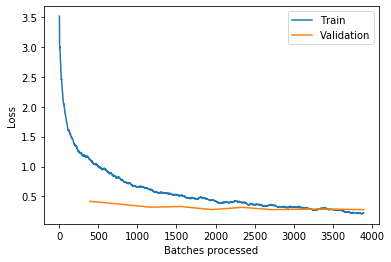

In [16]:
# Display the losses during the training sequence
learn.recorder.plot_losses()

In [0]:
# Load the model we just trained for fine tuning
learn.load('mobile_v1_stage-1');

In [18]:
# Exctract predictions and losses to evaluate model
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [0]:
# Define function that displays top_k accuracy
def top_k_spread(preds, y, spread):
  for i in range(spread):
    print(f"Top {i+1} accuracy: {top_k_accuracy(preds, y, i+1)}")

In [20]:
# Top-1 accuracy of 80% is quite near the best models from the open competition
top_k_spread(preds, y, 5)

Top 1 accuracy: 0.9044480919837952
Top 2 accuracy: 0.9736408591270447
Top 3 accuracy: 0.9950576424598694
Top 4 accuracy: 0.9983525276184082
Top 5 accuracy: 1.0


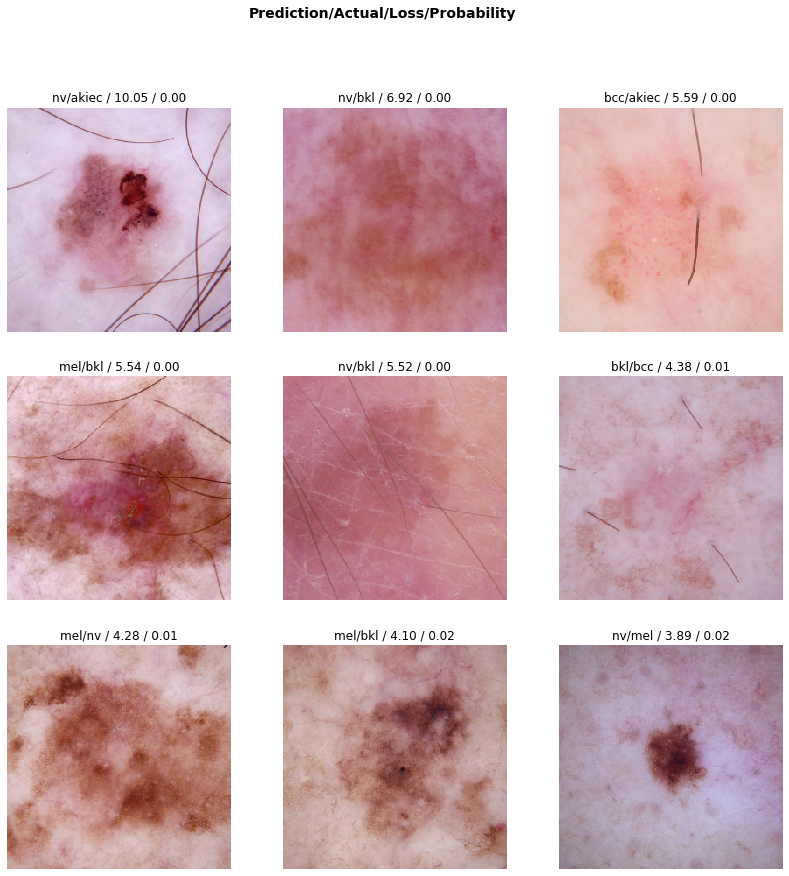

In [21]:
# Let's take a look at some of the samples that were most difficult for our model
interp.plot_top_losses(9, figsize=(14,14))

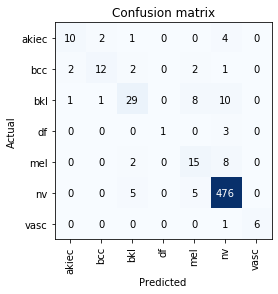

In [22]:
interp.plot_confusion_matrix()

In [23]:
# Which cell types are most often confused with eachother?
print('Actual, Predicted, Occurances')
interp.most_confused()

Actual, Predicted, Occurances


[('bkl', 'nv', 10),
 ('bkl', 'mel', 8),
 ('mel', 'nv', 8),
 ('nv', 'bkl', 5),
 ('nv', 'mel', 5),
 ('akiec', 'nv', 4),
 ('df', 'nv', 3),
 ('akiec', 'bcc', 2),
 ('bcc', 'akiec', 2),
 ('bcc', 'bkl', 2),
 ('bcc', 'mel', 2),
 ('mel', 'bkl', 2),
 ('akiec', 'bkl', 1),
 ('bcc', 'nv', 1),
 ('bkl', 'akiec', 1),
 ('bkl', 'bcc', 1),
 ('vasc', 'nv', 1)]

## Examples

In [0]:
import pandas as pd
import numpy as np
from random import random

import skimage as sk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

In [0]:
def plot_prediction(learner, index):
  data = learner.data.train_ds[index][0]
  pred = learner.predict(data)
  classes = learner.data.classes

  prediction = pd.DataFrame(to_np(pred[2]*100), columns=['Confidence'])
  prediction['Classes'] = classes
  prediction = prediction.sort_values(by='Confidence', ascending=False)

  fig = plt.figure(figsize=(12, 5))
  ax1 = fig.add_subplot(121)
  show_image(data, figsize=(5, 5), ax=ax1)
  ax2 = fig.add_subplot(122)
  sns.set_color_codes("pastel")
  sns.barplot(x='Confidence', y='Classes', data=prediction,
              label="Total", color="b")
  ax2.set_title(f'Actual: {learn.data.train_ds[index][1]}')

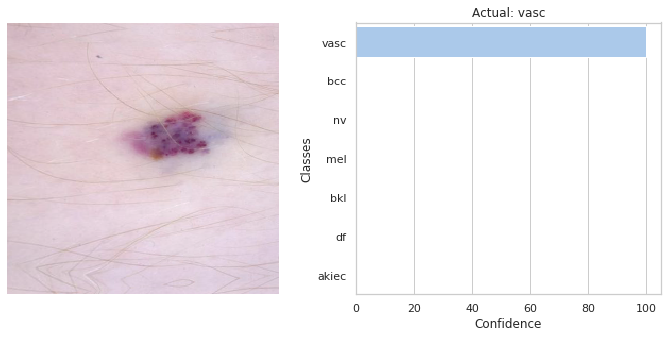

In [26]:
# Let's look at our prediciton confidence for an image in the training set
plot_prediction(learn, 913)

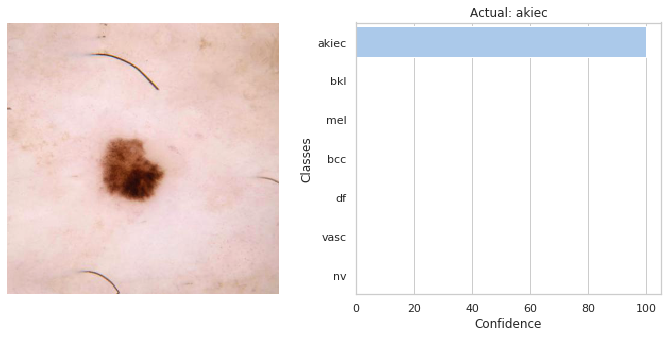

In [27]:
plot_prediction(learn, np.random.choice(len(learn.data.train_ds)))

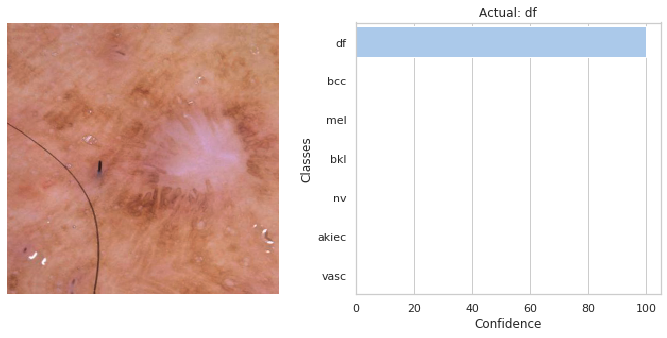

In [28]:
plot_prediction(learn, np.random.choice(len(learn.data.train_ds)))

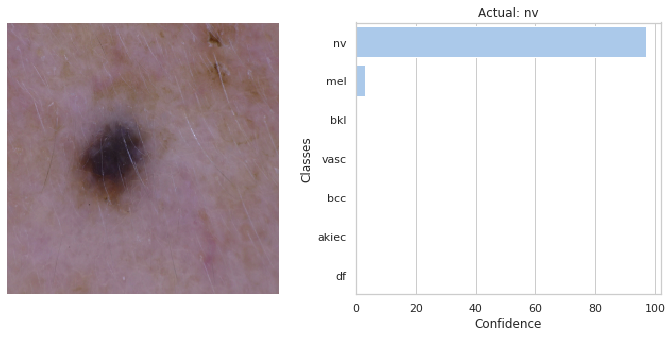

In [29]:
plot_prediction(learn, np.random.choice(len(learn.data.train_ds)))

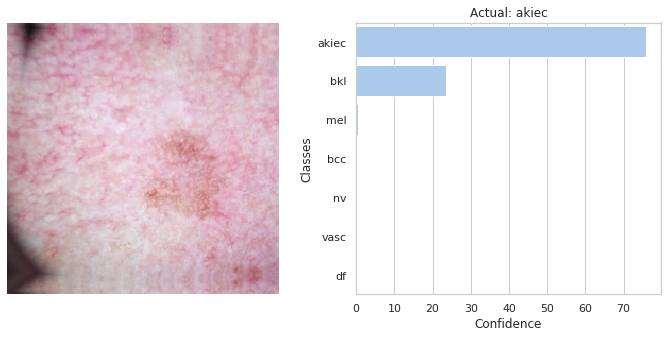

In [30]:
plot_prediction(learn, np.random.choice(len(learn.data.train_ds)))